In [23]:
import gym
import torch
import random
import warnings
import itertools
import numpy as np
import pandas as pd
import torch.nn as nn
from typing import Sequence
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import namedtuple, deque
from plot_script import plot_result, draw_neural_net
from torch.distributions.categorical import Categorical

warnings.filterwarnings("ignore")

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# DQN

In [2]:
GAMMA = 0.99
BATCH_SIZE = 64
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 5000
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 0.995
TARGET_UPDATE_FREQ = 5

In [3]:
env = gym.make("LunarLander-v2")
obs = env.reset()
episode_reward = 0.0

In [4]:
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))

class Replay_memory():

    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize)
        self.rewards = deque(maxlen=50)
        self.batchsize = batchsize
        self.minsize = minsize

    def append(self, transition):
        self.memory.append(transition)
    
    def sample_batch(self):
        batch = random.sample(self.memory, self.batchsize)
        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32)).to(device)
        actions = torch.from_numpy(np.array(batch.actions, dtype=np.int64)).unsqueeze(1).to(device)
        rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1).to(device)
        dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1).to(device)
        next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32)).to(device)
        
        return states, actions, rewards, dones, next_states

    def initialize(self):
        obs = env.reset()
        for _ in range(self.minsize):
            action = self.env.action_space.sample()
            new_obs, reward, done, info = env.step(action)
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                self.env.reset()
        return self

In [5]:
replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

In [6]:
class DQN(nn.Module):
    def __init__(self, ninputs, noutputs):
        super(DQN, self).__init__()
        self.a1 = nn.Linear(ninputs, 64, device=device)
        self.a2 = nn.Linear(64, noutputs, device=device)
    
    def forward(self, X):
        o = self.a1(X)
        o = torch.tanh(o)
        o = self.a2(o)
        
        return o
    
    def __call__(self, X):
        return self.forward(X)

In [7]:
dqn_policy = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target.load_state_dict(dqn_policy.state_dict())
dqn_target.eval()

DQN(
  (a1): Linear(in_features=8, out_features=64, bias=True)
  (a2): Linear(in_features=64, out_features=4, bias=True)
)

In [8]:
loss_fn = nn.SmoothL1Loss()
learning_rate = 0.001
optimizer = torch.optim.Adam(dqn_policy.parameters(), lr=learning_rate)

In [9]:
def epsilon_greedy_policy(epsilon, obs):
    rnd_sample = random.random()
    if rnd_sample <= epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            obs = torch.Tensor(obs).to(device)
            action = int(torch.argmax(dqn_policy(obs)))
    return action

## Training

In [10]:
obs = env.reset()
eps_threshold = EPS_START
episode = 1
history = []

for step in itertools.count():
    
    #Get action using Epsilon-Greedy Policy
    action = epsilon_greedy_policy(eps_threshold, obs)
    
    #Get the new observation and reward.
    new_obs, reward, done, _ = env.step(action)
    
    #Append to Replay Memory
    replay_memory.append(Transition(obs, action, reward, done, new_obs))
    episode_reward += reward
    obs = new_obs
    
    #If the episode is finished
    if done:
        
        episode += 1
        eps_threshold = np.max((eps_threshold*EPS_DECAY, EPS_END))
        replay_memory.rewards.append(episode_reward)
        obs = env.reset()
        avg_res = np.mean(replay_memory.rewards)
        history.append((episode-1, avg_res))
        
                
        if episode % 100 == 0: 
            print(f'Episode: {episode} Avg Results: {avg_res} Epsilon: {eps_threshold}')

        if avg_res >= 195:
            print(f'Solved at episode: {episode} Avg Results: {avg_res}')
            break
        
        if step % TARGET_UPDATE_FREQ == 0:
            dqn_target.load_state_dict(dqn_policy.state_dict())

        episode_reward = 0
    
    #Sample from the Replay Memory
    b_states, b_actions, b_rewards, b_dones, b_next_states = replay_memory.sample_batch()
    
    #Get Q-Values of every state-action pair from the Replay Memory Sample
    qvalues = dqn_policy(b_states).gather(1, b_actions)
    
    #Train the Neural Network to better evaluate the states observed.
    with torch.no_grad():
        target_qvalues = dqn_target(b_next_states)
        max_target_qvalues = torch.max(target_qvalues, axis=1).values.unsqueeze(1)
        expected_qvalues = b_rewards + GAMMA * (1 - b_dones.type(torch.int64)) * max_target_qvalues

    loss = loss_fn(qvalues, expected_qvalues)
    optimizer.zero_grad()
    loss.backward()
    for param in dqn_policy.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    

Episode: 100 Avg Results: -85.8809481477376 Epsilon: 0.6088145090359074
Episode: 200 Avg Results: 23.40181228420762 Epsilon: 0.36880183088056995
Episode: 300 Avg Results: 61.82237621482406 Epsilon: 0.22340924607110255
Episode: 400 Avg Results: 79.2416430407 Epsilon: 0.1353347165085562
Episode: 500 Avg Results: 185.08876833248848 Epsilon: 0.08198177029173696
Solved at episode: 545 Avg Results: 197.09773545252298


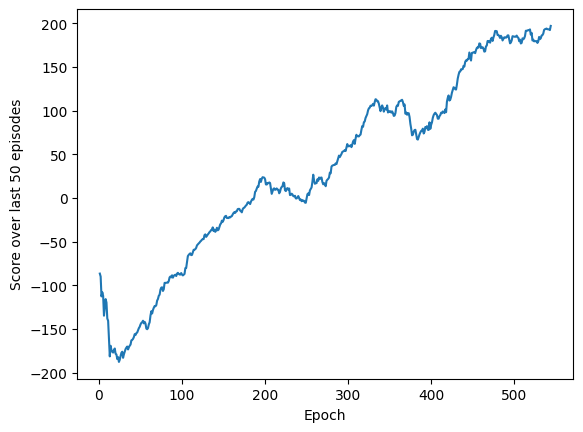

In [11]:
history = pd.DataFrame(
    history, columns=['Episode', 'Score'])

(fig, ax) = plt.subplots(1, 1)

ax.plot(history['Episode'], history['Score'])

ax.set_xlabel('Epoch')
ax.set_ylabel('Score over last 50 episodes')

plt.show()

# REINFORCE - Policy-Based Method

In [17]:
gamma = 0.99
MAX_EPISODES = 10_000

env = gym.make('LunarLander-v2')

In [18]:
class PolicyNet(nn.Module):
    def __init__(self, input_size, hidden_units=64, output_size=4):
        super(PolicyNet, self).__init__()
        self.l1 = nn.Linear(input_size, 16)
        self.l2 = nn.Linear(16, output_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        
        logits = self.l2(x)
        probs = F.softmax(logits, dim=-1)
        return probs

    def __call__(self, x):
        out = self.forward(x)
        return out

    
def discount_rewards(rewards):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for i in reversed(range(0, len(rewards))):
        cumulative_rewards = cumulative_rewards * gamma + rewards[i]
        discounted_rewards[i] = cumulative_rewards
    return discounted_rewards
    
    
    
policy = PolicyNet(input_size=env.observation_space.shape[0], hidden_units=16, output_size=env.action_space.n)
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.01)

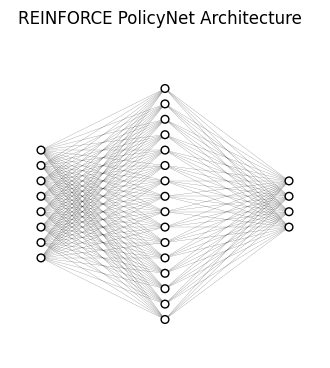

In [30]:
fig = plt.figure(figsize = (4,4))
fig.suptitle('REINFORCE PolicyNet Architecture')
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [8, 16, 4])

## Training

In [19]:
returns_log = deque(maxlen=50)
history = []

for episode in range(MAX_EPISODES):
    rewards = []
    actions = []
    states  = []
    done = False
    state = env.reset()
    while not done:
        with torch.no_grad():
            probs = policy(torch.tensor(state).unsqueeze(0).float())
            sampler = Categorical(probs)
            action = sampler.sample()

        new_state, reward, done, info = env.step(action.item())

        states.append(state)
        actions.append(action)
        rewards.append(reward)

        state = new_state
    
    rewards = np.array(rewards)
    R = torch.tensor(discount_rewards(rewards))

    states = torch.tensor(states).float()
    actions = torch.tensor(actions)

    probs = policy(states)
    sampler = Categorical(probs)
    log_probs = sampler.log_prob(actions)   
    loss = -torch.mean(log_probs * R) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    returns_log.append(np.sum(rewards))
    score = np.mean(returns_log)
    history.append((episode,score))
    
    
    print(f"Episode: {episode}  Average Return: {score}              ",end='\r')

    
    if episode>0 and episode % 100 == 0:
        print(f"Episode: {episode}  Average Return: {score}")

    if score >= 195:
        print(f"Solved! Episode: {episode} Average Return: {score}")
        break

Episode: 100  Average Return: -297.30651485181556              
Episode: 200  Average Return: -163.18606065301321              
Episode: 300  Average Return: -164.99192267611738              
Episode: 400  Average Return: -193.54737536864974              
Episode: 500  Average Return: -93.76159673483693               
Episode: 600  Average Return: -55.61240941263054               
Episode: 700  Average Return: -29.783156447516113              
Episode: 800  Average Return: -57.177219770866685              
Episode: 900  Average Return: -39.916515190950406              
Episode: 1000  Average Return: -25.66154528422807              
Episode: 1100  Average Return: -13.410723605023009              
Episode: 1200  Average Return: 1.533109492002831                
Episode: 1300  Average Return: -1.2505024535660332              
Episode: 1400  Average Return: 37.937208652361406               
Episode: 1500  Average Return: 78.86752250823743               
Episode: 1600  Average Return: 22.69

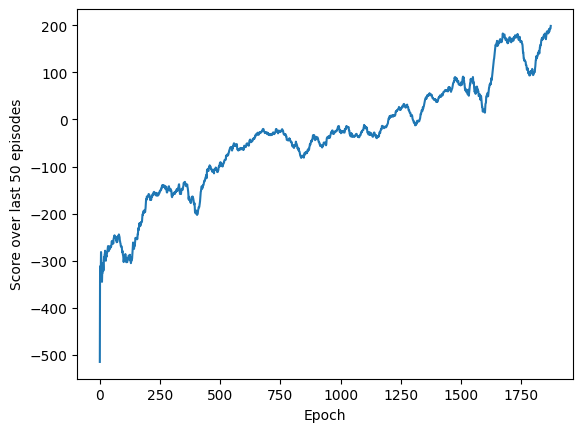

In [20]:
history = pd.DataFrame(
    history, columns=['Episode', 'Score'])

(fig, ax) = plt.subplots(1, 1)

ax.plot(history['Episode'], history['Score'])

ax.set_xlabel('Epoch')
ax.set_ylabel('Score over last 50 episodes')

plt.show()